# Установка Tesseract-ocr для распознавания элементов судоку. Для работы с Tesseract из Python также устанавливается обертка Pytesseract.

In [1]:
!sudo apt install tesseract-ocr
!pip install pytesseract

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 49 not upgraded.
Need to get 4,816 kB of archives.
After this operation, 15.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1.1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr amd64 4.1.1-2.1build1 [236 kB]
Fetched 4,816 kB in 2s (3,064 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debc

## Чтобы проверить, корректно ли установился Tesseract проверим его версию

In [2]:
!tesseract --version

tesseract 4.1.1
 leptonica-1.82.0
  libgif 5.1.9 : libjpeg 8d (libjpeg-turbo 2.1.1) : libpng 1.6.37 : libtiff 4.3.0 : zlib 1.2.11 : libwebp 1.2.2 : libopenjp2 2.4.0
 Found AVX2
 Found AVX
 Found FMA
 Found SSE
 Found libarchive 3.6.0 zlib/1.2.11 liblzma/5.2.5 bz2lib/1.0.8 liblz4/1.9.3 libzstd/1.4.8


## Импорт необходимых библиотек

In [3]:
import cv2
import numpy as np
import pytesseract
from google.colab.patches import cv2_imshow

## Функции для подготовки изображений

In [117]:
def preProcess(img, flag, size):
  '''
  Производит препроцессинг изображения - переводит в градации серого, добавляет
  размытие для уменьшения шума и возвращает его бинаризированное представление.

  Args:
    img : numpy.ndarray
      Изображение в виде массива numpy

  Returns:
    imgTreshold : numpy.ndarray
      Изображения с контурами в виде массива numpy
  '''
  img = cv2.resize(img, (size, size))
  imgGray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # конвертация в оттенки серого
  if flag:
    imgGray = cv2.GaussianBlur(imgGray, (5, 5), 1) # добавление размытия
  imgTreshold = cv2.adaptiveThreshold(imgGray, 255, 1, 1, 11, 2) # адаптивная бинаризация, для получения контуров

  return imgGray, imgTreshold

def splitBoxes(img, margin=5):
  '''
  Разбивает изображение на 81 ячейки с обрезкой краёев для избежания захвата границ сетки.

  Args:
    img : numpy.ndarray
      Изображение
    margin : int
      Отступ от границы изображения

  Returns:
    boxes : list
      Список изображений, разбитых на ячейки
  '''
  rows = np.vsplit(img, 9)
  boxes = []
  for r in rows:
    cols = np.hsplit(r, 9)
    for box in cols:
      h, w = box.shape[:2]
      box_crop = box[margin:h-margin, margin:w-margin]
      boxes.append(box_crop)
  return boxes

def stackImages(imgArray, scale):
  '''
  Объединяет несколько изображений в одно, масштабируя их по заданному коэффициенту.
  Располагает несколько изображений по сетке для их удобного отображения в одном окне.

  Args:
  ---------
    imgArray : list
      Список изображений для объединения - одномерный или матрица изображений
    scale : float
      Коэффициент масштабирования изображений

  Returns:
  ---------
    ver : numpy.ndarray
      Объединенное изображение. Если вход матрица, то возвращает сетку изображений.
      Если вход одномерный, то возвращает горизонтальную линию изображений.

  Примечания:
  ---------
  - Автоматически приводит размер всех изображений к размеру первого изображения
    в массиве.
  - Автоматически приводит ч\б изображения к цветному формату для совместимости.
  '''
  rows = len(imgArray)
  cols = len(imgArray[0])
  rowsAvailable = isinstance(imgArray[0], list)
  width = imgArray[0][0].shape[1]
  height = imgArray[0][0].shape[0]
  if rowsAvailable:
    for x in range(0, rows):
      for y in range(0, cols):
        imgArray[x][y] = cv2.resize(imgArray[x][y], (0, 0), None, scale, scale)
        if len(imgArray[x][y].shape) == 2:
          imgArray[x][y] = cv2.cvtColor(imgArray[x][y], cv2.COLOR_GRAY2BGR)
    imageBlank = np.zeros((height, width, 3), np.uint8)
    hor = [imageBlank]*rows
    hor_con = [imageBlank]*rows
    for x in range(0, rows):
      hor[x] = np.hstack(imgArray[x])
      hor_con[x] = np.concatenate(imgArray[x])
    ver = np.vstack(hor)
  else:
    for x in range(0, rows):
      imgArray[x] = cv2.resize(imgArray[x], (0, 0), None, scale, scale)
      if len(imgArray[x].shape) == 2:
        imgArray[x] = cv2.cvtColor(imgArray[x], cv2.COLOR_GRAY2BGR)
    ver = np.hstack(imgArray)
  return ver

## Функции для нахождения контуров и извлечения поля судоку

In [118]:
def biggestContour(contours):
  '''
  Находит самый большой контур и возвращает его и его площадь.

  Args:
    contours : typle(numpy.ndarray)
      Кортеж найденных контуров

  Returns:
    biggest : numpy.ndarray
      Самый большой контур
    max_area : float
      Площадь самого большого контура
  '''
  biggest = np.array([])
  max_area = 0 # площадь области контура - ищем контур с наибольшей площадью
  for i in contours:
    area = cv2.contourArea(i)
    if area > 50:
      peri = cv2.arcLength(i, True) # периметр контура
      approx = cv2.approxPolyDP(i, 0.02*peri, True) # аппроксимация контура
      if area > max_area and len(approx) == 4: # наибольшая площадь и 4 угла
        biggest = approx
        max_area = area

  return biggest, max_area


def reorder(myPoints):
  '''
  Перестраивает точки контура в правильном порядке - верхний левый, верхний правый, нижний правый и нижний левый угол.

  Args:
    myPoints : numpy.ndarray
      Массив точек контура

  Returns:
    myPointsNew : numpy.ndarray
      Перестроенный массив точек контура
  '''
  myPoints = myPoints.reshape((4, 2))
  myPointsNew = np.zeros((4, 1, 2), np.int32)
  add = myPoints.sum(1)
  myPointsNew[0] = myPoints[np.argmin(add)]
  myPointsNew[3] = myPoints[np.argmax(add)]
  diff = np.diff(myPoints, axis=1)
  myPointsNew[1] = myPoints[np.argmin(diff)]
  myPointsNew[2] = myPoints[np.argmax(diff)]

  return myPointsNew


def extract_digits_from_sudoku(image):
  '''
  Функция для извлечения цифр из поля судоку

  Args:
    image : numpy.ndarray
      Изображение с судоку

  Returns:
    result : list
      Лист с распознанными цифрами, 0 - пустая ячейка
  '''
  custom_config = r'--oem 3 --psm 6 outputbase digits' # конфигурация для tesseract OCR
  boxes = splitBoxes(image)

  result = []
  for i, box in enumerate(boxes):
    boxContr = cv2.convertScaleAbs(box, alpha=1.5, beta=0) # повышение контрастности изображения
    digit = pytesseract.image_to_string(boxContr, config=custom_config)
    if digit.strip() == '':
      result.append(0)
    else:
      # Либо из пустой ячейки, ошибочно классифицированной как пустая, извлекается не цифровой символ, либо из цифровой ячейки не извлекается цифра.
      # В случае с пустой ячейкой добавление 0 оправдано логикой работы алгоритма решения.
      # В случае с цифровой ячейкой идет расчет на то, что алгоритм найдет решение и без нескольких подсказок.
      try:
        result.append(int(digit))
      except:
        result.append(0)
  return result

## Функции для решения судоку с использованием алгоритма Backtracking

In [119]:
def is_valid(board, row, col, num):
  '''
  Проверяет, можно ли встаивть число в позицию (row, col).

  Args:
    board : list(list)
      Матричное представление поля судоку
    row : int
      Строка в которой нужно проверить
    col : int
      Столбец в котором нужно проверить
    num : int
      Число которое нужно проверить

  Returns:
    bool
  '''
  # Проверка строки
  for x in range(9):
    if board[row][x] == num:
      return False

  # Проверка столбца
  for y in range(9):
    if board[y][col] == num:
      return False

  # Проверка блока 3х3
  start_row = row - row % 3
  start_col = col - col % 3
  for i in range(3):
    for j in range(3):
      if board[i + start_row][j + start_col] == num:
        return False

  return True


def solve_sudoku(board):
  '''
  Рекурсивно решает судоку с помощью алгоритма Backtracking.

  Args:
    board : list(list)
      Матричное представление поля судоку

  Returns:
    bool
  '''
  empty_cell = find_empty_location(board)

  # если пустых ячеек нет, значит судоку решено
  if not empty_cell:
    return True
  row, col = empty_cell

  for num in range(1, 10):
    if is_valid(board, row, col, num):
      # если число можно вставить, то вставляем
      board[row][col] = num

      # рекурсивно решаем следующую ячейку
      if solve_sudoku(board):
        return True

      # если не получилось, то возвращаемся назад
      board[row][col] = 0

  return False


def find_empty_location(board):
  '''
  Находит пустую клетку судоку.

  Args:
    board : list(list)
      Матричное представление поля судоку

  Returns:
    tuple(int, int)
      Позиция пустой клетки
  '''
  for i in range(9):
    for j in range(9):
      if board[i][j] == 0:
        return (i, j)
  return None


def solve_sudoku_from_array(sudoku_array):
  '''
  Решает судоку из одномерного массива. Возвращает решенное судоку в виде матрицы.

  Args:
    sudoku_array : list
      Одномерное представление поля судоку

  Returns:
    list(list)
      Матричное представление поля судоку
  '''
  board = [sudoku_array[i:i+9] for i in range(0, 81, 9)]

  # решение судоку
  if solve_sudoku(board):
    return board
  else:
    return None


## Функция для создания изображения решенного судоку

In [120]:
def create_sudoku_image(sudoku_original, sudoku_solved, size):
  '''
  Создает изображение судоку из решенной матрицы.

  Args:
    sudoku_original : list(list)
      Матричное представление поля судоку, извлеченное с изображения

    sudoku_solved : list(list)
      Матричное представление решенного судоку

  Returns:
    img : numpy.ndarray
      Изображение судоку
  '''
  # размеры каждой ячейки
  cell_size = size // 9

  # белый фон
  img = np.ones((size, size, 3), dtype=np.uint8) * 255

  # шрифт для цифр
  font = cv2.FONT_HERSHEY_SIMPLEX
  font_scale = 1
  thickness = 2

  # отрисовка сетки
  for i in range(10):
    thickness_grid = 3 if i%3 == 0 else 1 # более толстые линии для блоков 3х3
    cv2.line(img, (0, i*cell_size), (size, i*cell_size), (0, 0, 0), thickness_grid) # горизонтальные линии
    cv2.line(img, (i*cell_size, 0), (i*cell_size, size), (0, 0, 0), thickness_grid) # вертикальыне линии

  # заполнение ячеек
  for row in range(9):
    for col in range(9):
      text = str(sudoku_solved[row][col])
      # расчет позиции для размещения текста
      text_size = cv2.getTextSize(text, font, font_scale, thickness)[0]
      text_x = col * cell_size + (cell_size - text_size[0]) // 2
      text_y = row * cell_size + (cell_size + text_size[1]) // 2
      if sudoku_original[row][col] == 0:
        test_color = (255, 0, 0)
      else:
        test_color = (0, 0, 0)
      cv2.putText(img, text, (text_x, text_y), font, font_scale, test_color, thickness)

  return img

## Функция для запуска всех этапов решения

In [121]:
def solve(path_to_image, SIZE=450, print_all_images=False):
  '''
  Функция для запуска всех этапов решения - обработки, извлечения, решения, формирования ответа.

  Args:
    path_to_image : string
      Путь до изображения с судоку
    SIZE : int
      Размер изображения. Должно быть кратным 9 для корректного вырезания ячеек. По умолчанию 450
    print_all_images : bool
      Флаг для печати всех этапов решения. По умолчанию False

  Returns:
    img : numpy.ndarray
      Изображение с решенным судоку
  '''
  image = cv2.imread(path_to_image) # считывание изображения
  img = cv2.resize(image, (SIZE, SIZE)) # изменение размеров изображения

  imgGray, imgThreshold = preProcess(img, False, SIZE)

  imgContours = img.copy()
  imgBigContours = img.copy()
  # Поиск конутров на изображении. cv2.RETR_EXTERNAL - флаг для поиска только внешних контуров
  # cv2.CHAIN_APPROX_SIMPLE - метод аппроксимации контуров, который упрощает их представление. Удаляет все точки кроме угловых, что понижает расходование памяти.
  contours, hierarchy = cv2.findContours(imgThreshold, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[-2:]
  # imgContours - изображение, на котором будут отрисованы контуры, contours - список найденных контуров,
  # -1 - индекс контура, который нужно отрисовать, при -1 будут отрисованы все
  # (0, 255, 0) - цвет отрисовываемого контура в формате BGR (зеленый)
  # 10 - толщина линии
  cv2.drawContours(imgContours, contours, -1, (0, 255, 0), 10)
  print('Контуры найдены...')

  biggest, maxArea = biggestContour(contours)

  if biggest.size != 0: # если самый большой контур найден
    print('Найдено поле...')
    biggest = reorder(biggest) # переопределяем порядок точек контура
    cv2.drawContours(imgBigContours, biggest, -1, (0, 0, 255), 15) # отрисовываем наибольший контур
    pts1 = np.float32(biggest)
    pts2 = np.float32([[0, 0], [SIZE, 0], [0, SIZE], [SIZE, SIZE]]) # Подготовка точек
    matrix = cv2.getPerspectiveTransform(pts1, pts2) # матрица преобразования для изменения перспективы
    imgWarpColored = cv2.warpPerspective(img, matrix, (SIZE, SIZE)) # преобразование
    imgWarpColored = cv2.cvtColor(imgWarpColored, cv2.COLOR_BGR2GRAY) # конвертация в оттенки серого
  else:
    print('Контур поля не найден! Используйте фотографию, где четко видно поле и его границы. На фотографии должно быть только одно поле.')
    return False

  print('Выделение ячеек поля...')
  grid = extract_digits_from_sudoku(imgWarpColored)
  grid_matrx = [grid[i:i+9] for i in range(0, 81, 9)]
  print('Извлеченное поле:')
  cv2_imshow(create_sudoku_image(grid_matrx, grid_matrx, SIZE))

  print('Поиск решения...')
  solved_sudoku = solve_sudoku_from_array(grid)

  if solved_sudoku is not None:
    print('Решение найдено! Подготовка изображения...')
    grid = [grid[i:i+9] for i in range(0, 81, 9)]
    solved_sudoku_image = create_sudoku_image(grid, solved_sudoku, SIZE)
    if print_all_images:
      imgBlank = np.zeros((SIZE, SIZE, 3), np.uint8)
      imageArray = ([img, imgThreshold, imgContours, imgWarpColored], [solved_sudoku_image, imgBlank, imgBlank, imgBlank])
      stackedImages = stackImages(imageArray, 1)
      cv2_imshow(stackedImages)
    else:
      cv2_imshow(solved_sudoku_image)
    return True
  else:
    print("Невозможно решить")
    return False


Контуры найдены...
Найдено поле...
Выделение ячеек поля...
Извлеченное поле:


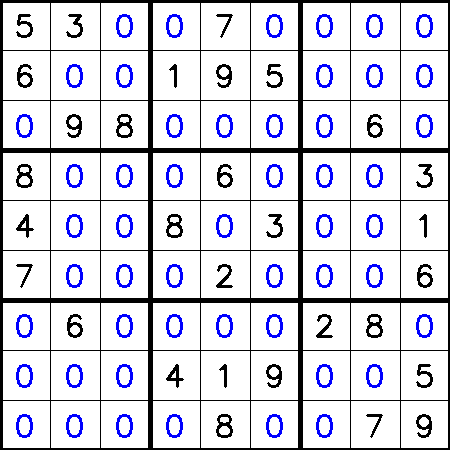

Поиск решения...
Решение найдено! Подготовка изображения...


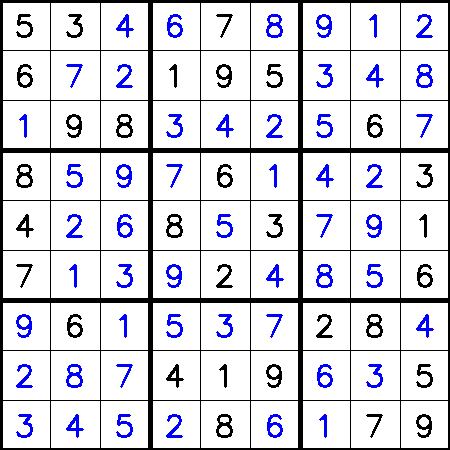

True

In [132]:
path = '/test1.png'
SIZE = 450
solve(path, SIZE, False) # при установке True выводит изображений всех этапов решения